In [6]:
import collections
import pandas as pd
import plotly.express as px
import wikipedia
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
import concurrent.futures
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='wikipedia')
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import shapely.geometry
from shapely.geometry import MultiPolygon
from skimage import io

In [7]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [8]:
def getOrigin(artist):
    us_states = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]
    context_types = ['(musician)','(rapper)','(band)']
    artist_metadata = ''
    try:
        artist_metadata = bs(wikipedia.page(artist, auto_suggest=False).html(),'html.parser').find('table',{'class': lambda e: e.startswith('infobox') if e else False})
    except wikipedia.DisambiguationError:
        idx = -1
        for context in context_types:
            try:
                artist_metadata = bs(wikipedia.page(artist+' '+context, auto_suggest=False).html(),'html.parser').find('table',{'class': lambda e: e.startswith('infobox') if e else False})
                break
            except:
                pass
    except:
        pass
    if not artist_metadata:
        return None,None
    img = artist_metadata.find('td',{'class':'infobox-image'})
    matches = [ele for ele in us_states if ele in str(artist_metadata)]
    if 'U.S.' in str(artist_metadata) and matches:
        pred_state = us_state_to_abbrev[matches[0]]
    else:
        pred_state = None
    if img:
        pred_img = 'https://'+img.a.img['src'][2:]
    else:
        pred_img = None
    return pred_state,pred_img


In [9]:
melon_df = pd.read_csv('melon_reviews.csv',lineterminator='\n')
del melon_df['Unnamed: 0']

In [10]:
with concurrent.futures.ThreadPoolExecutor() as executor: 
    temp = list(tqdm(executor.map(getOrigin, melon_df['artist']), total=len(melon_df['artist'])))
melon_df['us_state'] = [ele[0] for ele in temp ]
melon_df['img'] = [ele[1] for ele in temp]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2350/2350 [05:41<00:00,  6.87it/s]


In [48]:
geodict = {}
geodf = melon_df[['artist','us_state','img','score']].dropna()
geodf = geodf.groupby(['artist','us_state','img'])['score'].mean().reset_index()
for ele in geodf.to_dict('records'):
    artist,state,img,score = ele.values()
    if not state in geodict:
        geodict[state] = [artist,score,img]
    elif geodict[state][1] < score:
        geodict[state] = [artist,score,img]
geodict = pd.DataFrame([{'state':k,'artist':v[0],'score':v[1],'img':v[2]} for k,v in geodict.items()])
geodict

,state,artist,score,img
0,CA,Weyes Blood,9.000000,https://upload.wikimedia.org/wikipedia/commons...
1,NJ,Sharon Van Etten,6.750000,https://upload.wikimedia.org/wikipedia/commons...
2,MO,100 gecs,7.000000,https://upload.wikimedia.org/wikipedia/commons...
3,AL,Alabama Shakes,8.000000,https://upload.wikimedia.org/wikipedia/commons...
4,GA,Chloe x Halle,8.000000,https://upload.wikimedia.org/wikipedia/commons...
5,NY,A Tribe Called Quest,9.000000,https://upload.wikimedia.org/wikipedia/commons...
6,MT,ASAP Rocky,8.000000,https://upload.wikimedia.org/wikipedia/commons...
7,AZ,Vektor,8.000000,https://upload.wikimedia.org/wikipedia/commons...
8,IN,Adrianne Lenker,8.000000,https://upload.wikimedia.org/wikipedia/commons...
9,FL,Torche,8.000000,https://upload.wikimedia.org/wikipedia/commons...


In [49]:
geometry = gpd.read_file("cb_2018_us_state_500k/cb_2018_us_state_500k.shp").to_crs("ESRI:102009")
geometry = geometry.rename(columns ={'STUSPS':'state'})
geodict = geodict.merge(geometry, on='state', how = 'outer')
geodf = geodict[geodict["state"].isin(["HI","AK","VI","MP","GU","AS","PR"]) == False]

,state,artist,score
0,CA,Weyes Blood,9.000000
1,NJ,Sharon Van Etten,6.750000
2,MO,100 gecs,7.000000
3,AL,Alabama Shakes,8.000000
4,GA,Chloe x Halle,8.000000
5,NY,A Tribe Called Quest,9.000000
6,MT,ASAP Rocky,8.000000
7,AZ,Vektor,8.000000
8,IN,Adrianne Lenker,8.000000
9,FL,Torche,8.000000


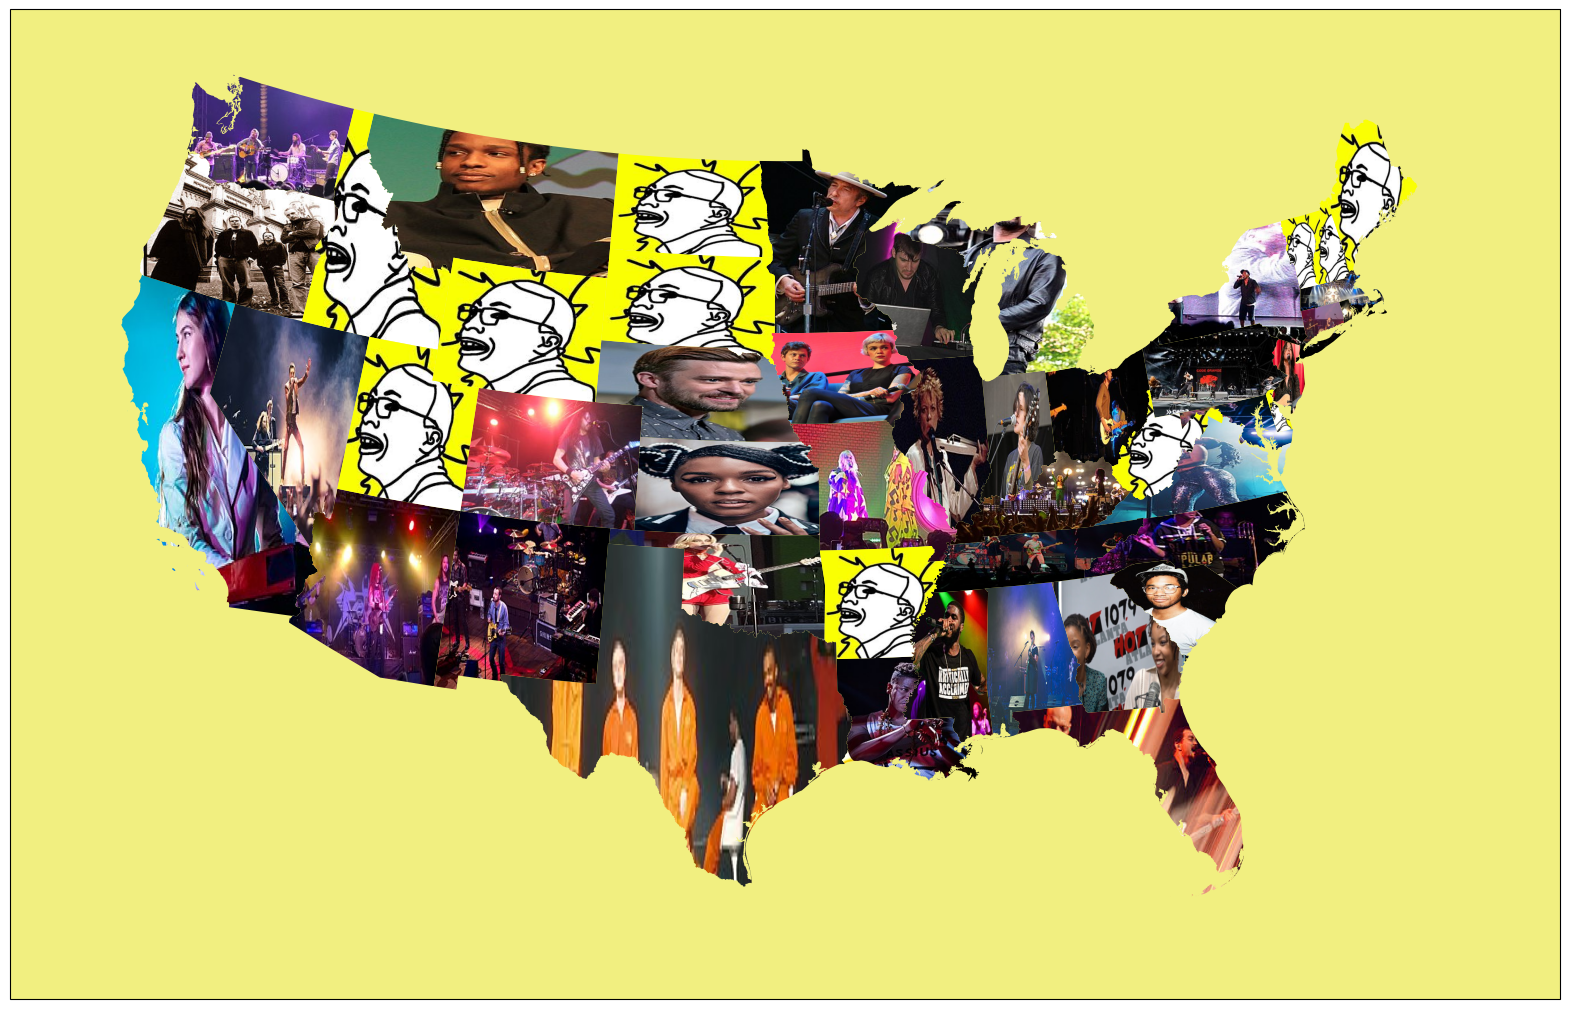

In [54]:
display(geodf[['state','artist','score']].dropna())

plt.figure(figsize=(20, 15),dpi = 100)
plt.title('Highest Reviewed US Artists By State')
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent((-120, -72, 20, 50))
ax.set_facecolor('#F1EF80')

for index, row in geodf.iterrows():     

    if type(row["img"]) == str:
        image = io.imread(row["img"])
    else:
        image = io.imread('fail.jpg')

    state = row['state']
    state_geometry = row['geometry']

    state_bb = list(state_geometry.bounds)
    state_bb[1],state_bb[2] = state_bb[2],state_bb[1]

    plate_carree_transform = ccrs.LambertConformal()._as_mpl_transform(ax)  

    if state_geometry.geometryType()=='MultiPolygon':
        for xy in state_geometry.geoms:
            coord_xy = xy.exterior.xy  
            xy_list = []
            for xy in zip(coord_xy[0], coord_xy[1]):
                xy_list.append([xy[0],xy[1]])
            image2 = ax.imshow(image,extent=state_bb, zorder=5)
            image2.set_clip_path(mpatches.Path(xy_list),transform= plate_carree_transform) 

    else:
        coord_xy = state_geometry.exterior.xy   
        xy_list = []
        for xy in zip(coord_xy[0], coord_xy[1]):
            xy_list.append([xy[0],xy[1]])
        image2 = ax.imshow(image, extent=state_bb,zorder=5) 
        image2.set_clip_path(mpatches.Path(xy_list),transform=plate_carree_transform) 
    pass